# Exploratory Data Analysis (2/2)
After using the ETL pipeline to load the data into a csv file, we can now use this data to perform some exploratory data analysis. This notebook documents 
* The preprocessing of the data for analysis
* Exploratory Data Analysis on this dataset 
* Visualizations of the data

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')

The data is loaded by chunks from the csv file into a pandas dataframe as it is a relatively large dataset

In [4]:
%%time
file_path = '../data/cleaned/taxi_data.csv'
chunksize = 10**6

with pd.read_csv(file_path, chunksize=chunksize) as reader:
    taxi_df = pd.concat([chunk for chunk in reader])

taxi_df.head()

CPU times: total: 16.6 s
Wall time: 23 s


,booking_id,driver_id,name,date_of_birth,gender,car_model,car_make_year,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,rating,safety_label
0,0,48,Lilia,1974-08-13,Male,Mercedes-Benz,2013-01-01,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,4.0,0
1,0,48,Lilia,1974-08-13,Male,Mercedes-Benz,2013-01-01,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,4.0,0
2,0,48,Lilia,1974-08-13,Male,Mercedes-Benz,2013-01-01,8.0,143.298294,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,9.0,0.228454,4.0,0
3,0,48,Lilia,1974-08-13,Male,Mercedes-Benz,2013-01-01,8.0,143.298294,-0.600986,-9.452029,-2.157507,0.004548,-0.011713,-0.004078,11.0,0.228454,4.0,0
4,0,48,Lilia,1974-08-13,Male,Mercedes-Benz,2013-01-01,8.0,143.298294,-0.597546,-9.863403,-1.672711,-0.000401,0.000315,-0.009830,12.0,0.228454,4.0,0


In [5]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7469656 entries, 0 to 7469655
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   booking_id      int64  
 1   driver_id       int64  
 2   name            object 
 3   date_of_birth   object 
 4   gender          object 
 5   car_model       object 
 6   car_make_year   object 
 7   accuracy        float64
 8   bearing         float64
 9   acceleration_x  float64
 10  acceleration_y  float64
 11  acceleration_z  float64
 12  gyro_x          float64
 13  gyro_y          float64
 14  gyro_z          float64
 15  second          float64
 16  speed           float64
 17  rating          float64
 18  safety_label    int64  
dtypes: float64(11), int64(3), object(5)
memory usage: 1.1+ GB


# Preprocessing
Initial preprocessing is done to prepare the data for Exploratory Data Analysis. This includes
* Extracting driver's age using their date of birth
* Extracting the car's year of make of make from car_make_year, removing day and month
* Converting seconds to minutes for easier analysis
* Converting speed from m/s to km/h for easier analysis
* Converting compass bearing to their general directions for ease of analysis (North, North-West, East, etc.)


Needs to be reviewed
* Calculate magnitude of acceleration (NOT CONFIRMED)
* Calculate magnitude of angular velocity (NOT CONFIRMED)
* Dropped driver_id, driver's date_of_birth, speed (m/s) and bearing (NOT CONFIRMED)

In [6]:
%%time

cleaned_df = taxi_df.copy()

# set date_of_birth to datetime
cleaned_df['date_of_birth'] = pd.to_datetime(cleaned_df['date_of_birth'])

# extract years from car_make_year
cleaned_df['car_make_year'] = cleaned_df['car_make_year'].apply(lambda x: int(x.split('-')[0]))

# calculate magnitude of acceleration sqrt(x^2 + y^2 + z^2)
a_x = cleaned_df['acceleration_x']
a_y = cleaned_df['acceleration_y']
a_z = cleaned_df['acceleration_z']
cleaned_df['MA (m/s^2)'] = np.sqrt(a_x**2 + a_y**2 + a_z**2)

# magnitude of angular velocity?
g_x = cleaned_df['gyro_x']
g_y = cleaned_df['gyro_y']
g_z = cleaned_df['gyro_z']
cleaned_df['MAV (rad/s)'] = np.sqrt(g_x**2 + g_y**2 + g_z**2)

# convert driver dob to age (current date - dob)
cleaned_df['driver_age'] = pd.to_datetime('today').year - cleaned_df['date_of_birth'].dt.year

# convert seconds to minutes
cleaned_df['duration (mins)'] = round(cleaned_df['second'] / 60, 2)

# convert speed (meters per second) to kilometers per hour
cleaned_df['speed (km/h)'] = cleaned_df['speed'] * 3.6

# convert bearing to categorical variable 
cleaned_df['direction'] = cleaned_df['bearing'].apply(
    lambda x: 
        'North' if x >= 337.5 or x < 22.5 else
        'North East' if x >= 22.5 and x < 67.5 else
        'East' if x >= 67.5 and x < 112.5 else
        'South East' if x >= 112.5 and x < 157.5 else
        'South' if x >= 157.5 and x < 202.5 else
        'South West' if x >= 202.5 and x < 247.5 else
        'West' if x >= 247.5 and x < 292.5 
        else 'North West'
)

# drop unnecessary columns
cols = ['driver_id', 'date_of_birth', 'speed', 'bearing']
cleaned_df.drop(columns=cols, inplace=True)

# reorder columns
cleaned_df = cleaned_df[['booking_id', 'name', 'driver_age', 'gender', 'car_model', 'car_make_year', 'accuracy', 'direction', 
                         'acceleration_x', 'acceleration_y', 'acceleration_z','MA (m/s^2)', 'gyro_x', 'gyro_y', 'gyro_z', 'MAV (rad/s)', 
                        'second', 'duration (mins)', 'speed (km/h)', 'rating', 'safety_label']]

CPU times: total: 14.1 s
Wall time: 22.5 s


First 5 rows of the dataset after preprocessing

In [7]:
# export cleaned dataset
cleaned_df.to_csv('../data/cleaned/cleaned_taxi_data.csv', index=False)
cleaned_df.head()

,booking_id,name,driver_age,gender,car_model,car_make_year,accuracy,direction,acceleration_x,acceleration_y,...,MA (m/s^2),gyro_x,gyro_y,gyro_z,MAV (rad/s),second,duration (mins),speed (km/h),rating,safety_label
0,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-1.706207,-9.270792,...,9.503762,-0.028965,-0.032652,0.015390,0.046282,2.0,0.03,0.822436,4.0,0
1,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-1.416705,-9.548032,...,9.830320,-0.022413,0.005049,-0.025753,0.034511,3.0,0.05,0.822436,4.0,0
2,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.346924,-9.532629,...,9.614707,0.014962,-0.050033,0.025118,0.057949,9.0,0.15,0.822436,4.0,0
3,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.600986,-9.452029,...,9.713747,0.004548,-0.011713,-0.004078,0.013210,11.0,0.18,0.822436,4.0,0
4,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.597546,-9.863403,...,10.022063,-0.000401,0.000315,-0.009830,0.009843,12.0,0.20,0.822436,4.0,0


# Exploratory Data Analysis
After preprocessing, we can now perform some exploratory data analysis on the dataset

## Descriptive Analysis

In [8]:
rows, columns = cleaned_df.shape
print(f'Number of rows: {rows}')
print(f'Number of columns: {columns}')

Number of rows: 7469656
Number of columns: 21


In [9]:
cleaned_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7469656 entries, 0 to 7469655
Data columns (total 21 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   booking_id       7469656 non-null  int64  
 1   name             7469656 non-null  object 
 2   driver_age       7469656 non-null  int64  
 3   gender           7469656 non-null  object 
 4   car_model        7469656 non-null  object 
 5   car_make_year    7469656 non-null  int64  
 6   accuracy         7351631 non-null  float64
 7   direction        7469656 non-null  object 
 8   acceleration_x   7364539 non-null  float64
 9   acceleration_y   7346553 non-null  float64
 10  acceleration_z   7370520 non-null  float64
 11  MA (m/s^2)       7148013 non-null  float64
 12  gyro_x           7336398 non-null  float64
 13  gyro_y           7329944 non-null  float64
 14  gyro_z           7404168 non-null  float64
 15  MAV (rad/s)      7136620 non-null  float64
 16  second           7

In [10]:
unique_vals = cleaned_df.nunique().to_frame('unique values')
display(unique_vals)

,unique values
booking_id,20000
name,147
driver_age,24
gender,2
car_model,10
car_make_year,10
accuracy,38534
direction,8
acceleration_x,904124
acceleration_y,854584


## Summary Statistics

In [11]:
cleaned_df.describe().T

,count,mean,std,min,25%,50%,75%,max
booking_id,7469656.0,8.183371e+11,4.953348e+11,0.000000,3.779571e+11,8.074539e+11,1.254130e+12,1.709397e+12
driver_age,7469656.0,3.929782e+01,6.689755e+00,27.000000,3.300000e+01,4.000000e+01,4.500000e+01,5.000000e+01
car_make_year,7469656.0,2.009430e+03,2.402120e+00,2004.000000,2.008000e+03,2.011000e+03,2.011000e+03,2.013000e+03
accuracy,7351631.0,1.162066e+01,8.727007e+01,0.750000,3.900000e+00,4.247000e+00,8.000000e+00,6.070101e+03
acceleration_x,7364539.0,6.918624e-02,1.424023e+00,-38.983994,-5.087219e-01,6.130981e-02,6.355286e-01,6.687346e+01
acceleration_y,7346553.0,4.467981e+00,8.130443e+00,-57.800190,-2.026514e+00,9.081485e+00,9.710308e+00,7.281000e+01
acceleration_z,7370520.0,8.964518e-01,3.252218e+00,-78.448420,-9.295166e-01,7.776642e-01,2.753036e+00,7.805576e+01
MA (m/s^2),7148013.0,9.893230e+00,1.267685e+00,0.005074,9.549204e+00,9.817876e+00,1.013328e+01,9.563782e+01
gyro_x,7336398.0,-1.738806e-03,1.445958e-01,-48.455750,-2.679080e-02,-6.561279e-04,2.329046e-02,3.870809e+01
gyro_y,7329944.0,2.046962e-04,3.371285e-01,-57.344890,-2.996360e-02,2.583960e-04,3.142024e-02,8.031496e+01


In [12]:
gender_stats = cleaned_df.groupby('gender').describe()

print('\033[1mDriver age by gender\033[0m')
display(gender_stats['driver_age'])

print('\033[1mSensor accuracy by gender\033[0m') # idk what this means prob remove?
display(gender_stats['accuracy'])

print('\033[1mMagnitude of acceleration by gender\033[0m')
display(gender_stats['MA (m/s^2)'])

print('\033[1mMagnitude of angular velocity by gender\033[0m')
display(gender_stats['MAV (rad/s)'])

print('\033[1mTrip duration (s) by gender\033[0m')
display(gender_stats['second'])

print('\033[1mTrip duration (m) by gender\033[0m')
display(gender_stats['duration (mins)'])

print('\033[1mTrip speed (km/h) by gender\033[0m')
display(gender_stats['speed (km/h)'])

print('\033[1mRating by gender\033[0m')
display(gender_stats['rating'])

Driver age by gender


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,2793286.0,37.673408,6.503547,27.0,32.0,37.0,44.0,49.0
Male,4676370.0,40.268113,6.610797,27.0,35.0,41.0,45.0,50.0


Sensor accuracy by gender


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,2749058.0,11.829539,93.493825,0.80,3.9,4.283,8.0,6070.101
Male,4602573.0,11.495900,83.331014,0.75,3.9,4.228,8.0,5250.773


Magnitude of acceleration by gender


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,2673112.0,9.889531,1.235693,0.014916,9.550299,9.818739,10.134600,88.162371
Male,4474901.0,9.895439,1.286412,0.005074,9.548564,9.817380,10.132497,95.637824


Magnitude of angular velocity by gender


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,2668533.0,0.130332,0.437670,0.0,0.028204,0.067009,0.143240,62.156582
Male,4468087.0,0.128595,0.330479,0.0,0.027743,0.066514,0.143376,80.777981


Trip duration (s) by gender


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,2793286.0,1041.453534,5.240455e+05,0.0,241.0,519.0,861.0,619315595.0
Male,4676370.0,5239.018749,1.694298e+06,0.0,242.0,520.0,863.0,619316528.0


Trip duration (m) by gender


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,2793286.0,17.357558,8734.091180,0.0,4.02,8.65,14.35,10321926.58
Male,4676370.0,87.316979,28238.295224,0.0,4.03,8.67,14.38,10321942.13


Trip speed (km/h) by gender


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,2746991.0,32.576078,29.163305,-7.2,3.78,27.468000,55.980001,316.934114
Male,4599088.0,32.317358,29.189558,-3.6,3.60,26.882778,55.547996,148.703616


Rating by gender


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,2793286.0,4.096461,0.561565,3.0,3.5,4.0,4.5,5.0
Male,4676370.0,4.074709,0.526176,3.0,3.5,4.0,4.5,5.0


In [13]:
car_model_stats = cleaned_df.groupby('car_model').describe()

print('\033[1mDriver age by car model\033[0m')
display(car_model_stats['driver_age'])

print('\033[1mSensor accuracy by car model\033[0m') # idk what this means prob remove?
display(car_model_stats['accuracy'])

print('\033[1mMagnitude of acceleration by car model\033[0m')
display(car_model_stats['MA (m/s^2)'])

print('\033[1mMagnitude of angular velocity by car model\033[0m')
display(car_model_stats['MAV (rad/s)'])

print('\033[1mTrip duration (s) by car model\033[0m')
display(car_model_stats['second'])

print('\033[1mTrip duration (m) by car model\033[0m')
display(car_model_stats['duration (mins)'])

print('\033[1mTrip speed (km/h) by car model\033[0m')
display(car_model_stats['speed (km/h)'])

print('\033[1mRating by car model\033[0m')
display(car_model_stats['rating'])

Driver age by car model


,count,mean,std,min,25%,50%,75%,max
car_model,,,,,,,,
BMW,152227.0,44.278223,5.204623,37.0,37.0,48.0,48.0,48.0
Chevrolet,558107.0,39.123387,7.005023,30.0,33.0,38.0,48.0,49.0
Ford,769289.0,38.347755,6.250744,29.0,32.0,40.0,43.0,48.0
Honda,551485.0,40.698140,7.548163,27.0,32.0,44.0,47.0,49.0
Hyundai,814208.0,38.841588,5.973429,31.0,34.0,38.0,45.0,49.0
Mazda,805665.0,37.325347,7.117978,29.0,30.0,36.0,45.0,48.0
Mercedes-Benz,416104.0,40.883385,8.237530,28.0,36.0,45.0,49.0,50.0
Nissan,919729.0,41.313273,6.405729,28.0,39.0,42.0,46.0,49.0
Toyota,1510162.0,39.230907,6.215856,28.0,35.0,40.0,45.0,49.0


Sensor accuracy by car model


,count,mean,std,min,25%,50%,75%,max
car_model,,,,,,,,
BMW,149843.0,13.842455,103.403956,2.00,3.9,4.000,8.0,3504.000
Chevrolet,549308.0,11.757110,80.886869,0.90,3.9,4.685,8.8,3732.000
Ford,757061.0,11.421946,83.814948,0.80,3.9,4.000,8.0,5646.000
Honda,542908.0,12.397390,100.039480,0.90,3.9,4.288,8.0,5107.384
Hyundai,801391.0,10.816601,78.785065,0.90,3.9,4.269,8.0,4000.000
Mazda,792879.0,11.870747,83.299377,1.50,3.9,4.516,8.0,2511.000
Mercedes-Benz,409561.0,12.458590,87.271461,1.00,3.9,4.000,8.0,2678.000
Nissan,905083.0,10.849983,79.244484,0.80,3.9,4.049,8.0,5250.773
Toyota,1486287.0,11.611977,93.473909,0.80,3.9,4.288,8.0,6070.101


Magnitude of acceleration by car model


,count,mean,std,min,25%,50%,75%,max
car_model,,,,,,,,
BMW,145706.0,9.827634,0.945139,0.014916,9.523706,9.801675,10.108261,88.162371
Chevrolet,534083.0,9.957660,1.832900,0.164945,9.552976,9.820819,10.140123,56.528426
Ford,736205.0,9.866419,0.896822,0.007859,9.552896,9.820782,10.129123,75.902973
Honda,527869.0,9.876780,0.926616,0.572570,9.553188,9.823315,10.139232,88.527242
Hyundai,779206.0,9.953826,1.821869,0.005074,9.548743,9.819262,10.144286,95.637824
Mazda,770915.0,9.864555,0.878121,0.221784,9.543444,9.816141,10.131617,78.848716
Mercedes-Benz,398061.0,9.861581,0.831149,0.891313,9.553663,9.814987,10.121298,80.144296
Nissan,880177.0,9.901360,1.280831,0.454004,9.555083,9.820480,10.139249,67.890992
Toyota,1445175.0,9.882488,1.200022,0.033486,9.547205,9.817222,10.131083,65.495506


Magnitude of angular velocity by car model


,count,mean,std,min,25%,50%,75%,max
car_model,,,,,,,,
BMW,145506.0,0.177060,0.741552,0.0,0.028299,0.068602,0.150894,36.387575
Chevrolet,533262.0,0.127805,0.295390,0.0,0.028184,0.067341,0.144030,42.894486
Ford,734893.0,0.125587,0.317573,0.0,0.028027,0.067033,0.143866,55.582833
Honda,526899.0,0.124999,0.254246,0.0,0.028523,0.068576,0.145820,21.673311
Hyundai,777903.0,0.129981,0.333377,0.0,0.027299,0.065762,0.142621,58.216896
Mazda,769808.0,0.126938,0.319365,0.0,0.028114,0.067271,0.143563,80.777981
Mercedes-Benz,397576.0,0.122829,0.316338,0.0,0.026436,0.063009,0.139009,71.127359
Nissan,879058.0,0.128048,0.311099,0.0,0.028233,0.067078,0.144280,62.156582
Toyota,1442797.0,0.131087,0.496100,0.0,0.027961,0.066141,0.141749,52.263240


Trip duration (s) by car model


,count,mean,std,min,25%,50%,75%,max
car_model,,,,,,,,
BMW,152227.0,603.359529,4.448491e+02,0.0,243.0,529.0,876.0,3043.0
Chevrolet,558107.0,12804.813478,2.749448e+06,0.0,240.0,519.0,862.0,619316528.0
Ford,769289.0,617.521873,5.373635e+02,0.0,244.0,523.0,870.0,8234.0
Honda,551485.0,606.286463,4.668757e+02,0.0,242.0,522.0,871.0,5987.0
Hyundai,814208.0,18096.006648,3.291562e+06,0.0,238.0,515.0,864.0,619315876.0
Mazda,805665.0,603.846799,4.574223e+02,0.0,243.0,523.0,865.0,4064.0
Mercedes-Benz,416104.0,2095.003970,9.600871e+05,0.0,243.0,526.0,869.0,619315523.0
Nissan,919729.0,603.712740,4.551206e+02,0.0,243.0,523.0,867.0,4064.0
Toyota,1510162.0,598.638296,4.485534e+02,0.0,242.0,520.0,861.0,4499.0


Trip duration (m) by car model


,count,mean,std,min,25%,50%,75%,max
car_model,,,,,,,,
BMW,152227.0,10.056001,7.414151,0.0,4.05,8.82,14.60,50.72
Chevrolet,558107.0,213.413559,45824.140544,0.0,4.00,8.65,14.37,10321942.13
Ford,769289.0,10.292033,8.956056,0.0,4.07,8.72,14.50,137.23
Honda,551485.0,10.104773,7.781259,0.0,4.03,8.70,14.52,99.78
Hyundai,814208.0,301.600109,54859.362149,0.0,3.97,8.58,14.40,10321931.27
Mazda,805665.0,10.064109,7.623705,0.0,4.05,8.72,14.42,67.73
Mercedes-Benz,416104.0,34.916729,16001.452088,0.0,4.05,8.77,14.48,10321925.38
Nissan,919729.0,10.061878,7.585346,0.0,4.05,8.72,14.45,67.73
Toyota,1510162.0,9.977307,7.475887,0.0,4.03,8.67,14.35,74.98


Trip speed (km/h) by car model


,count,mean,std,min,25%,50%,75%,max
car_model,,,,,,,,
BMW,149736.0,33.286871,29.679283,-3.600000,3.554365,28.352755,57.960000,126.617857
Chevrolet,548960.0,32.878205,29.303297,-3.600000,4.083058,27.720000,56.700000,129.170243
Ford,756626.0,32.105657,29.180559,-6.191193,3.272398,26.604000,55.187884,128.736000
Honda,542249.0,32.538306,29.224382,-3.600000,3.844483,27.277387,56.046384,148.703616
Hyundai,800953.0,32.486877,29.282143,-3.600000,3.645450,27.063044,55.980000,131.948424
Mazda,792168.0,33.066600,29.474893,-3.600000,4.104000,28.017814,56.546161,153.026654
Mercedes-Benz,409197.0,31.587879,28.762131,-3.600000,3.225057,26.100000,54.126605,316.934114
Nissan,904442.0,32.094599,28.921321,-3.600000,3.598173,26.768987,55.049589,181.980000
Toyota,1485262.0,32.617302,29.275855,-7.200000,3.780000,27.383634,55.920473,154.106446


Rating by car model


,count,mean,std,min,25%,50%,75%,max
car_model,,,,,,,,
BMW,152227.0,4.188459,0.463125,3.5,3.5,4.5,4.5,4.5
Chevrolet,558107.0,4.118223,0.545060,3.5,3.5,4.0,4.5,5.0
Ford,769289.0,4.107715,0.573825,3.0,3.5,4.0,4.5,5.0
Honda,551485.0,4.024734,0.576979,3.5,3.5,4.0,4.5,5.0
Hyundai,814208.0,4.071648,0.558056,3.0,3.5,4.0,4.5,5.0
Mazda,805665.0,4.095549,0.609924,3.0,3.5,4.0,4.5,5.0
Mercedes-Benz,416104.0,4.192685,0.243342,4.0,4.0,4.0,4.5,4.5
Nissan,919729.0,3.985097,0.515968,3.0,3.5,4.0,4.5,4.5
Toyota,1510162.0,4.101123,0.567987,3.0,4.0,4.0,4.5,5.0


## Univariate Analysis

In [14]:
# histogram of all numerical columns

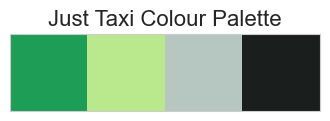

In [15]:
# set font family
hfont = {'fontname':'Arial'}
# set colour palette for better visualisations
palette = ['#1e9d56', '#bae88c', '#b6c7c1', '#1a1f1e']

sns.palplot(palette)
plt.title('Just Taxi Colour Palette', fontsize=16)
plt.grid(False)
plt.show()

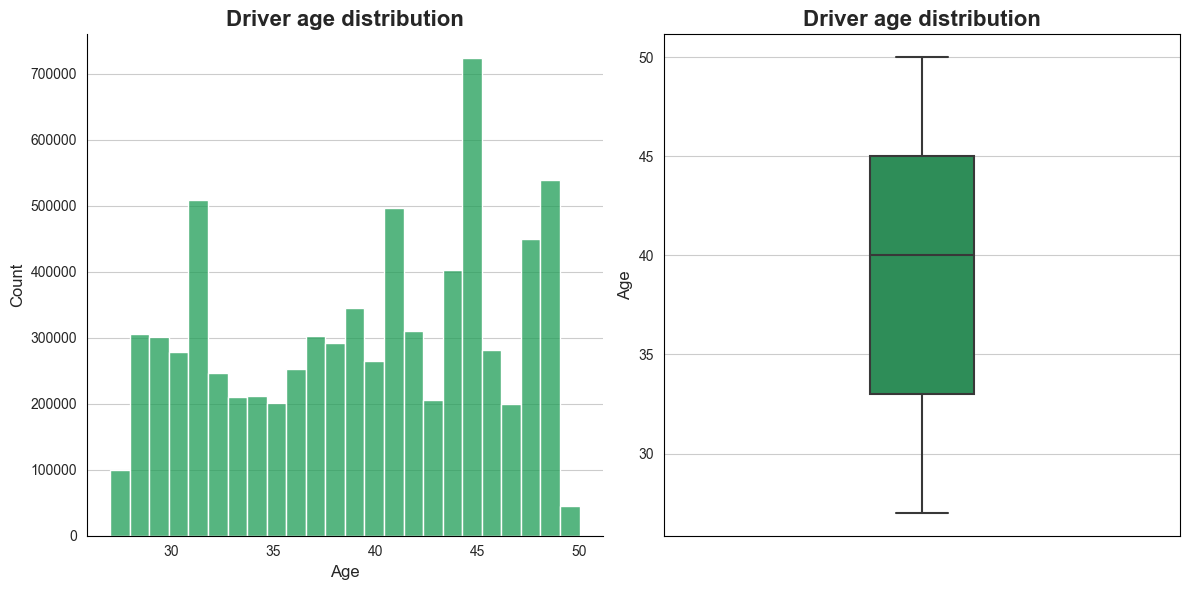

In [16]:
fig, axes = plt.subplots(1, 2 ,figsize=(12, 6))

sns.histplot(x=cleaned_df['driver_age'], bins=24, color=palette[0], edgecolor='white', ax=axes[0])
axes[0].set_title('Driver age distribution', fontweight='semibold', fontsize=16, **hfont)
axes[0].set_xlabel('Age', fontsize=12, **hfont)
axes[0].set_ylabel('Count', fontsize=12, **hfont)
axes[0].grid(axis='x')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_color('k')
axes[0].spines['bottom'].set_color('k')

# boxplot of drivers age by gender
sns.boxplot(y=cleaned_df['driver_age'], color=palette[0], width=.2, ax=axes[1])
axes[1].set_title('Driver age distribution', fontweight='semibold', fontsize=16, **hfont)
axes[1].set_ylabel('Age', fontsize=12, **hfont)
axes[1].spines[:].set_color('k')

plt.tight_layout()
plt.show()

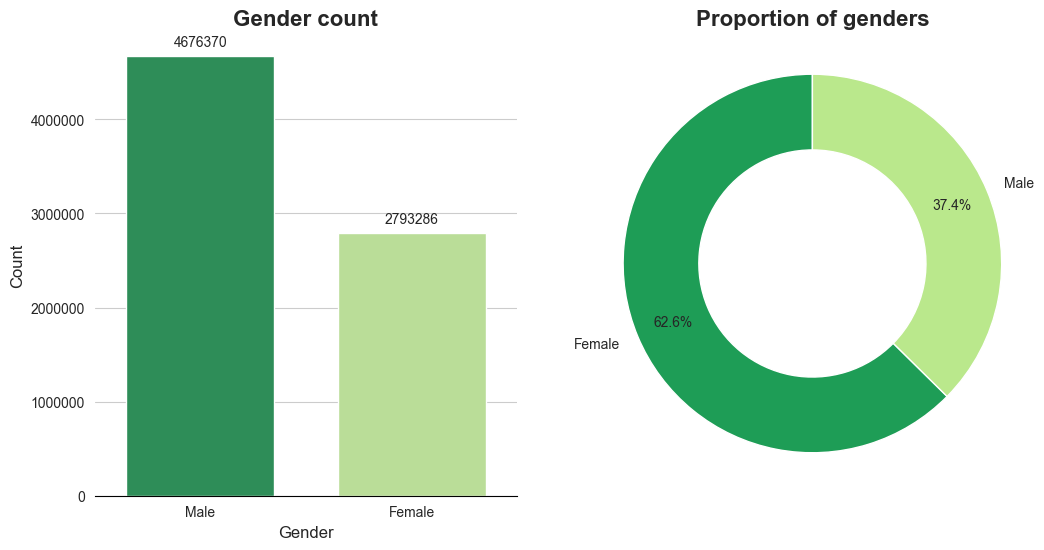

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# bar chart
sns.countplot(x=cleaned_df['gender'], width=.7, edgecolor='white', palette=palette, ax=axes[0])
axes[0].set_title('Gender count', fontsize=16, fontweight='semibold', **hfont)
axes[0].set_xlabel('Gender', fontsize=12, **hfont)
axes[0].set_ylabel('Count', fontsize=12, **hfont)
axes[0].get_yaxis().get_major_formatter().set_scientific(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_color('k')

# annotate bar chart
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

# donut chart
labels = np.unique(cleaned_df['gender'])
sizes = cleaned_df['gender'].value_counts()

axes[1].pie(sizes, colors=palette, labels=labels, autopct='%.1f%%', pctdistance=.8, labeldistance=1.1,
          startangle=90, radius=1, wedgeprops=dict(width=.4, edgecolor='white'))
axes[1].set_title('Proportion of genders', fontsize=16, fontweight='semibold', **hfont)
axes[1].axis('equal')
plt.show()

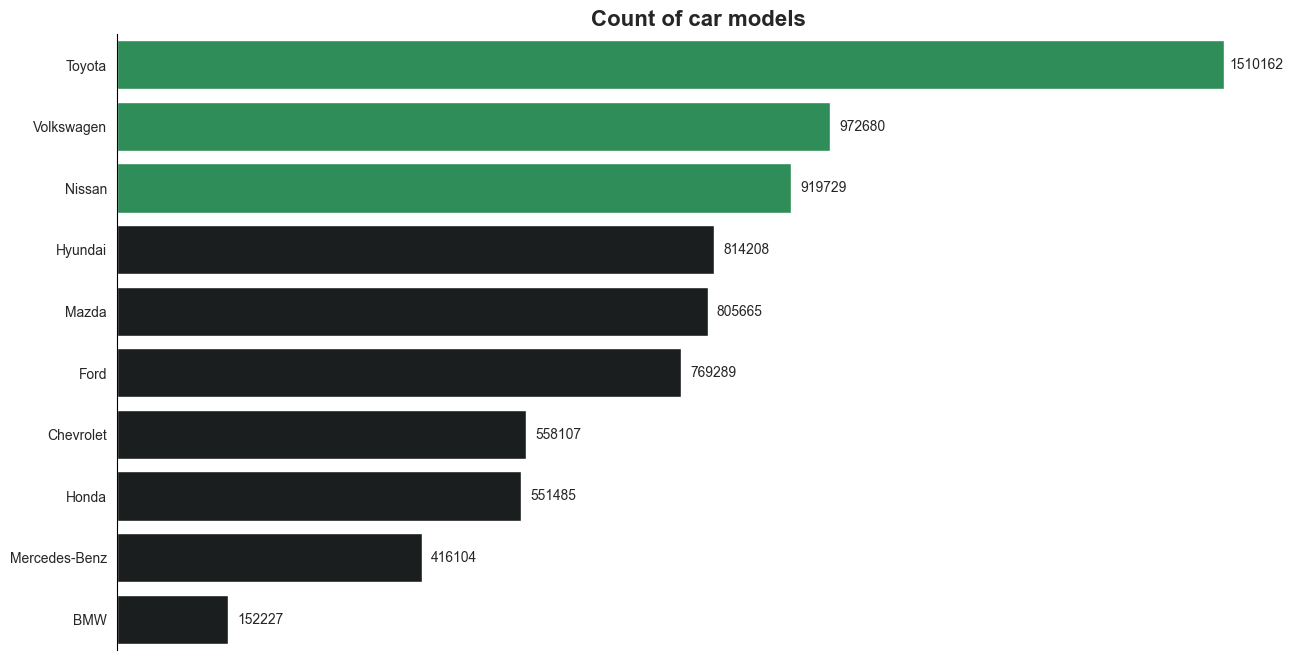

In [20]:
colors = [palette[-1] for _ in range(10)]
colors[0] = colors[1] = colors[2] = palette[0]

# plot horizontal countplot of car models in order of count
plt.figure(figsize=(15, 8))
ax = sns.countplot(y=cleaned_df['car_model'], order=cleaned_df['car_model'].value_counts().index,
                palette=colors, edgecolor='white')

plt.title('Count of car models', fontsize=16, fontweight='semibold', **hfont)
plt.xticks([])
plt.xlabel('')
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_visible(False)

# annotate countplot
for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', (p.get_width() + 10**4.4, p.get_y() + p.get_height() / 2.), 
                ha='center', va='center', xytext=(10, 0), textcoords='offset points', fontsize=10)

# highlight top 3 car models - WIP

plt.show()

In [19]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7469656 entries, 0 to 7469655
Data columns (total 21 columns):
 #   Column           Dtype  
---  ------           -----  
 0   booking_id       int64  
 1   name             object 
 2   driver_age       int64  
 3   gender           object 
 4   car_model        object 
 5   car_make_year    int64  
 6   accuracy         float64
 7   direction        object 
 8   acceleration_x   float64
 9   acceleration_y   float64
 10  acceleration_z   float64
 11  MA (m/s^2)       float64
 12  gyro_x           float64
 13  gyro_y           float64
 14  gyro_z           float64
 15  MAV (rad/s)      float64
 16  second           float64
 17  duration (mins)  float64
 18  speed (km/h)     float64
 19  rating           float64
 20  safety_label     int64  
dtypes: float64(13), int64(4), object(4)
memory usage: 1.2+ GB
